# Voice activity detection
Voice activity detection (VAD) are algorithms which decide for a single block of audio, if it is background noise or human speech. VAD algorithms are typically very fast and simple to implement. Therefore, the VAD can run continuously on an input stream from a microphone. Only in the case of active human voice, the audio feature extraction and classification is performed, which are usually much more complex algorithms. By this, the overall computational complexity is reduced a lot and a lot of energy consumption is saved.

The behaviour of VAD is shown for the following recording:

Assuming a recording situation with  39.231162413242934  dB of SNR.


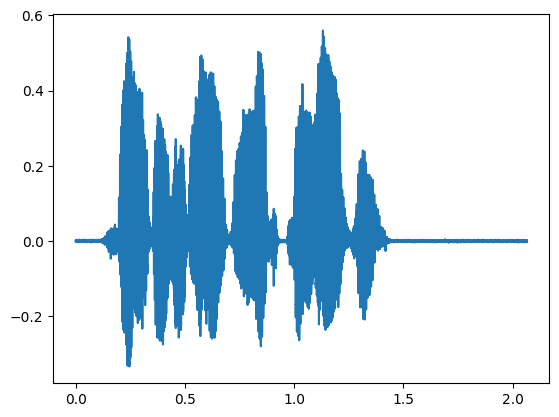

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, '../Python')
import WaveInterface

x, Fs, bits = WaveInterface.ReadWave('../Python/Voice/PferdeSchnaubenNichtDieNase.wav')
y = x + 0.001 * np.random.randn(x.shape[0])
SNR = 10*np.log10(np.sum(x**2) / np.sum((x-y)**2))
print('Assuming a recording situation with ', SNR, ' dB of SNR.')

t = np.arange(y.shape[0]) / Fs
plt.plot(t, y)
plt.show()

## VAD feature: level
In a typical recording situation the human voice is louder than the background noise. Otherwise, it would the voice would be hard to recognize even for human listeners.

Therefore, the level in dB FS of a block of audio is a reasonable feature for detecting human voice:

Text(0, 0.5, 'L [dB FS]')

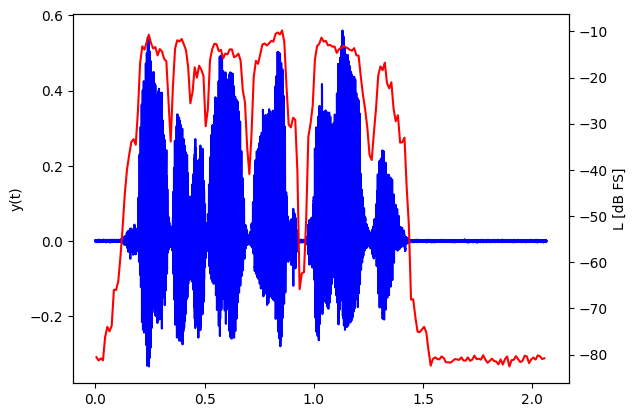

In [9]:
def EvaluateLevel(x):
    A = 1 # maximum magnitude of a wave file
    P = np.mean(x**2)
    L = 10*np.log10(2*P/(A**2))
    return L
    
BlocksizeInMs = 10
BlocksizeInSamples = int(BlocksizeInMs * Fs / 1000)
NumberOfBlocks = x.shape[0] // BlocksizeInSamples
L = np.zeros((NumberOfBlocks))
for n in range(NumberOfBlocks):
    idx1 = n * BlocksizeInSamples
    idx2 = idx1 + BlocksizeInSamples
    L[n] = EvaluateLevel(x[idx1:idx2])

fig = plt.figure(1)
ax = fig.add_subplot(111)
t = np.arange(y.shape[0]) / Fs
ax.plot(t, y, 'b')
ax.set_ylabel('y(t)')
ax2 = ax.twinx()
t = (np.arange(L.shape[0]) + 0.5) * BlocksizeInMs / 1000
ax2.plot(t, L, 'r')
ax2.set_ylabel('L [dB FS]')


## Threshold
Audio feature are usually measured in a continous way. E.g. the level in dB FS is usually in the range from $-100$ dB Fs up to $0$ dB FS. In order to decide, which block is voice and which block is background noise, a threshold must be defined.

The histogram of the measured level values shows two distributions of the level values:

One is located around $-25$ dB FS, one is located around $-80$ dB FS. The higher values belongs to human speech, the lower values belong to the background noise.

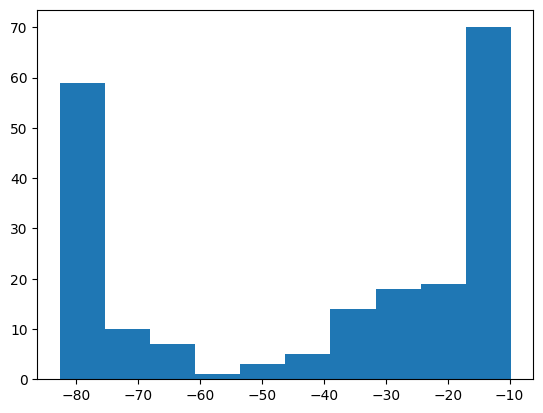

In [10]:
plt.hist(L)
plt.show()

Based on the historgram shown above, the threshold is set to $-40$ dB FS.

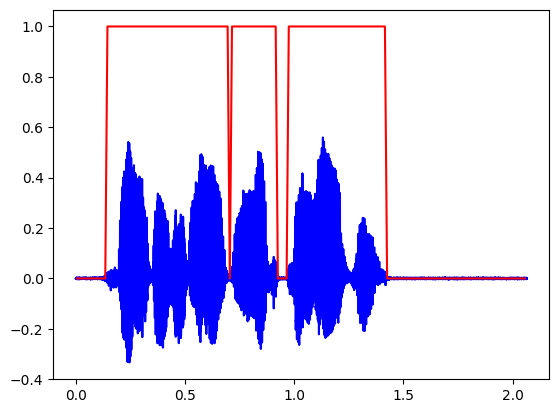

In [11]:
ThresholdLevel = -40
IsSpeech = L > ThresholdLevel

t = np.arange(y.shape[0]) / Fs
plt.plot(t, y, 'b')
t = (np.arange(IsSpeech.shape[0]) + 0.5) * BlocksizeInMs / 1000
plt.plot(t, IsSpeech, 'r')
plt.show()

## Blockwise analysis
In the following a blocksize of $10$ ms is chosen for analysing the recording.
If the former block is not speech and the current block is speech, the beginning of a word is assumed.
If the former block is speech and the current block is not speech, the ending of a word is assumed.
The beginning and the ending of a word is defined by the variable "IsTriggered".

In [12]:
IndexOfWord = 0
IsTriggered = False
for n in range(1, IsSpeech.shape[0]):
    CurrentSamplingPosition = int(n * BlocksizeInMs / 1000 * Fs)
    if (not IsSpeech[n-1]) and (IsSpeech[n]) and (not IsTriggered):
        IsTriggered = True
        BeginningOfWordInSamples = CurrentSamplingPosition
    if (IsSpeech[n-1]) and (not IsSpeech[n]) and (IsTriggered):
        IsTriggered = False
        EndingOfWordInSamples = CurrentSamplingPosition
        FileName = 'VAD_WordNumber_' + str(IndexOfWord) + '.wav'
        IndexOfWord += 1
        WordSamples = y[BeginningOfWordInSamples:EndingOfWordInSamples]
        WaveInterface.WriteWave(WordSamples, Fs, bits, FileName)
print(IndexOfWord, ' words detected')

3  words detected


## Programming exercise
The level in dB FS is heavily depending on the SNR of the recording. The above suggested algorithm will fail if the SNR falls below a certain value.

The zero crossing rate is an audio feature independent from the level of the speech signal and the level of the background noise. The zero crossing rate is defined by:

$\text{zcr} = \frac{1}{N-1}\sum_{n=1}^{N-1} \varepsilon\left(-x(n)\cdot x(n-1)\right)$

with the unit step $\varepsilon\left(x\right)$ defined as follows:

$\varepsilon(x) = \begin{cases}
        1 & \text{if } x \geq 0\\
        0 & \text{else}
    \end{cases}$

A small value of zcr corresponds to speech, a large value corresponds to noise.

Implement the procedure Unitstep and the procedure EvaluateZCR.

Additionally, implement the Pearson correlation.

Finally, implement a blockwise analysis of $x$: evaluate the local zcr and the local level for the blocks. Evaluate the Pearson correlation between all zcr and levels.

In [18]:
def Unitstep(x):
    result = 0.0
    ### solution
    result = (x >= 0) + 0.0
    ### solution
    return result

def EvaluateZCR(x):
    zcr = 0.0
    ### solution
    zcr = np.mean(Unitstep(-x[1:]*x[:-1]))
    ### solution
    return zcr

def PearsonCorrelation(x, y):
    phi = 0
    ### solution
    x_zeromean = x - np.mean(x)
    y_zeromean = y - np.mean(y)
    phi = np.sum(x_zeromean * y_zeromean) / np.sqrt(np.sum(x_zeromean**2) * np.sum(y_zeromean**2))
    ### solution
    return phi

def EvaluateCorrelationBetweenBlockwiseZCRAndLevel(x):
    phi = 0.0
    ### solution
    BlocksizeInMs = 10
    BlocksizeInSamples = int(BlocksizeInMs * Fs / 1000)
    NumberOfBlocks = x.shape[0] // BlocksizeInSamples
    zcr = np.zeros((NumberOfBlocks))
    L = np.copy(zcr)    
    for n in range(NumberOfBlocks):
        idx1 = n * BlocksizeInSamples
        idx2 = idx1 + BlocksizeInSamples
        x_block = x[idx1:idx2]
        zcr[n] = EvaluateZCR(x_block)
        L[n] = EvaluateLevel(x_block)
    phi = PearsonCorrelation(zcr, L)
    ### solution
    return phi

import unittest

class TestProgrammingExercise(unittest.TestCase):

    def test_ZCR(self):
        r = 48000
        f = np.random.rand(1) * r / 2
        t = np.arange(r)/r
        x = np.cos(2*np.pi*f*t)
        ZCR = EvaluateZCR(x)
        self.assertAlmostEqual(ZCR*r, 2*f, delta = 10)
        
    def test_UnitstepScalar(self):
        x = np.random.randn(1)**2     
        self.assertAlmostEqual(Unitstep(x), 1.0, delta = 1e-15)
        x *= -1
        x -= 1e-15
        self.assertAlmostEqual(Unitstep(x), 0.0, delta = 1e-15)

    def test_UnitstepVector(self):
        x = np.arange(3) - 1
        self.assertAlmostEqual(Unitstep(x[0]), 0.0, delta = 1e-15)
        self.assertAlmostEqual(Unitstep(x[1]), 1.0, delta = 1e-15)
        self.assertAlmostEqual(Unitstep(x[2]), 1.0, delta = 1e-15)

    def test_EvaluateCorrelationBetweenZCRAndLevel(self):
        phi = EvaluateCorrelationBetweenBlockwiseZCRAndLevel(y)
        self.assertAlmostEqual(phi, -0.956, delta = 1e-2)

    def test_EvaluateCorrelationBetweenZCRAndLevelNoisy(self):
        x = np.random.randn(10000)
        phi = EvaluateCorrelationBetweenBlockwiseZCRAndLevel(x)
        self.assertLess(np.abs(phi), 0.5)

    def test_EvaluatePearsonCorrelation1(self):
        x = np.random.randn(10000)
        y = np.random.randn(10000)
        phi = PearsonCorrelation(x, y)
        self.assertLess(np.abs(phi), 0.2)

    def test_EvaluatePearsonCorrelation3(self):
        x = np.random.randn(10000)
        phi = PearsonCorrelation(x, -x)
        self.assertGreater(phi, -0.99)

    def test_EvaluatePearsonCorrelation3(self):
        x = np.random.randn(10000)
        phi = PearsonCorrelation(x, x)
        self.assertGreater(phi, 0.99)
    
unittest.main(argv=[''], verbosity=2, exit=False)

test_EvaluateCorrelationBetweenZCRAndLevel (__main__.TestProgrammingExercise.test_EvaluateCorrelationBetweenZCRAndLevel) ... ok
test_EvaluateCorrelationBetweenZCRAndLevelNoisy (__main__.TestProgrammingExercise.test_EvaluateCorrelationBetweenZCRAndLevelNoisy) ... ok
test_EvaluatePearsonCorrelation1 (__main__.TestProgrammingExercise.test_EvaluatePearsonCorrelation1) ... ok
test_EvaluatePearsonCorrelation3 (__main__.TestProgrammingExercise.test_EvaluatePearsonCorrelation3) ... ok
test_UnitstepScalar (__main__.TestProgrammingExercise.test_UnitstepScalar) ... ok
test_UnitstepVector (__main__.TestProgrammingExercise.test_UnitstepVector) ... ok
test_ZCR (__main__.TestProgrammingExercise.test_ZCR) ... ok

----------------------------------------------------------------------
Ran 7 tests in 0.037s

OK


## Exam preparation
1) Evaluate the zero crossing rate of a sinus with a frequency of $1234$ Hz.

2) How can the both features level and zero crossing rate mathematically combined to form a more robust better feature?

3) Plot the unit step function $\varepsilon(x)$ for $-2<x<2$. Is the unit step a linear function? Hint: For a linear function $f(x)$ the following must be true: $f(a\cdot x_1+b\cdot x_2) = a\cdot f\left(x_1\right)+b\cdot f\left(x_2\right)$.

4) Why are the timestamps of the blockwise features evaluated by the following equation: **t = (np.arange(IsSpeech.shape[0]) + 0.5) * BlocksizeInMs / 1000**. Explain especially the addition of the term $+0.5$.

5) What is the highest and the lowest possible zero crossing rate according to the above given algorithm? (hint: assuming big numbers of $N$)